In [1]:
using LinearAlgebra
using Plots

Podano imamo zanko v spodnjem zapisu:

In [2]:
a = 1
b = -(11/7)

x(t) = (a+b) * cos(t) + b * cos(((a+b)/b)*t)
y(t) = (a+b) * sin(t) + b * sin(((a+b)/b)*t)

y (generic function with 1 method)

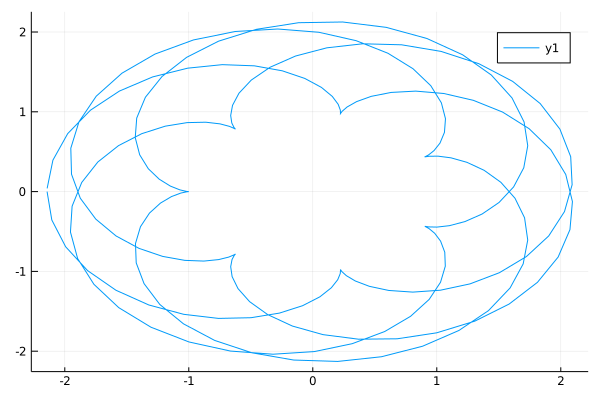

In [3]:
plot(x,y,0:0.314:22pi)         #22pi je perioda zanke, zračunano ročno

Želimo izračunati celotno površino, torej potrebujemo enačbo za zunanjo zanko. Za to nam prav pride polarni zapis koordinat. Ker polarni kot ni zvezen, imamo zanj dve enačbi, da se izognemo problemom pri računanju na prehodu.

In [4]:
polar_a(t) = atan(y(t),x(t))+pi
polar_a2(t) = atan(-x(t),y(t))+3pi/2
polar_d(t) = sqrt(x(t)^2+y(t)^2)

polar_d (generic function with 1 method)

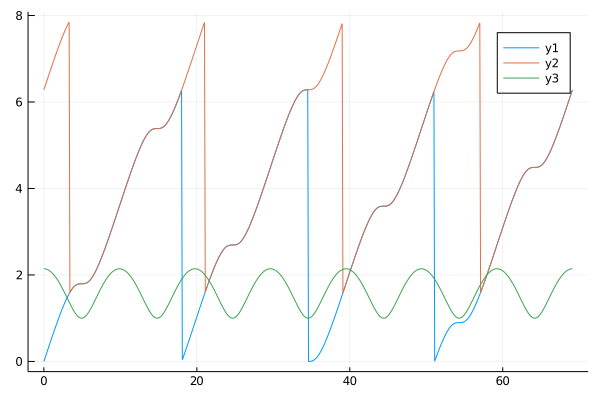

In [5]:
plot(polar_a,0:0.1:22pi)
plot!(polar_a2,0:0.1:22pi)
plot!(polar_d,0:0.1:22pi)

Želimo razdeliti zanko po enakomernih korakih kota, da potem dobimo maksimalno vredost zanke za vsak kot. Zato uporabimo sekantno metodo, da ne potrebujemo odvoda. Omejimo velikost koraka, da se izognemo problemu sekantne metode, kjer je skok prevelik če sta vrednosti prejšnih dveh približkov zelo blizu.

In [14]:
"""
    Funkcija za izkanje ničle prek sekantne metode.
    Vhod:
        f: funkcija, katere ničlo iščemo
        x1: prvi začetni približek
        x2: drugi začetni približek
        maxit: maksimalno število iteracij
        tol: toleranca
    Izhod:
        x: izračunan približek
        it: število iteracij
"""

function sekantna(f, x1, x2, maxit=1000, tol = 1e-12)
      
    x = 0
    
    for i=1:maxit
        fx1 = f(x1)
        fx2 = f(x2)
        
        step = (fx2 * (x2-x1))/(fx2-fx1)
        
        step = clamp(step,-0.1,0.1)
        
        x = x2 - step

        x1 = x2
        x2 = x #0.9*x2+0.1*x
        
        if abs(f(x)) < tol
            return x,i
        end
        
    end
    
    return x,maxit
        
end

sekantna (generic function with 3 methods)

Metoda, ki nam izračuna zaporedje vrednosti t tako, da dobimo enakomerne korake po kotu. Za prva dva približka za sekantno metodo vzamemo 
prejšnje dve vrednosti t.

In [40]:
"""
    Funkcija, ki izračuna zaporedje vrednosti t, pri katerih je kot enakomeren
    Vhod:
        numdots: število točk na krožnici
        length: perioda funkcije, po kateri točki se ponavlja
        start: začetni odmik, pri katerem kotu začnemo
    Izhod:
        ts: Zaporedje vrednosti t, ki skupno naredijo kot "length" okoli središča, in je "numdots" vrednosti na krog
"""

function get_ts(numdots,length,start=0)

    ts = []

    t1 = 0
    t2 = 0.1

    #numdots = 2048*2

    for i=start:2pi/numdots:length-2pi/numdots+start

        i2 = (i-pi/2)%2pi+pi/2            #druga funckija je zvezna na intervalih pi/2 do 2pi+pi/2, zato rabimo i prilagoditi

        func1(t) = polar_a(t)-i%2pi+0.01
        func2(t) = polar_a2(t)-i2+0.01

        if polar_a(t2) < pi                #če smo blizu odseka prve funkcije, uporabimo drugo funkcijo
            t,it = sekantna(func1,t1,t2)
        else
            t,it = sekantna(func2,t1,t2)
        end
        
        if(it > 100)
            display(it)
        end

        t1 = t2
        t2 = t

        ts = vcat(ts,t)
    end

    return ts
end

get_ts (generic function with 2 methods)

Vrednosti t nato razdelimo po obhodih, in za vsak kot izračunamo tisti t, ki je najbolj oddaljen od središča. Tako dobimo zunanjo črto

In [72]:
"""
    Funkcija, ki iz zaporedja vrednosti ts izračuna maksimalno vrednost, za vsak kot.
"""

function get_maxts(ts)
    tsmat = Matrix(reshape(ts,:,4))
    tsrad = Matrix(polar_d.(tsmat))

    maxids = [findmax(tsrad[i,:])[2] for i=1:size(tsrad)[1]]

    maxts = [tsmat[i,maxids[i]] for i=1:size(tsmat)[1]]

    maxts = vcat(maxts,maxts[1])
    #maxts = vcat(maxts[end],maxts)
    
    return maxts
end

get_maxts (generic function with 1 method)

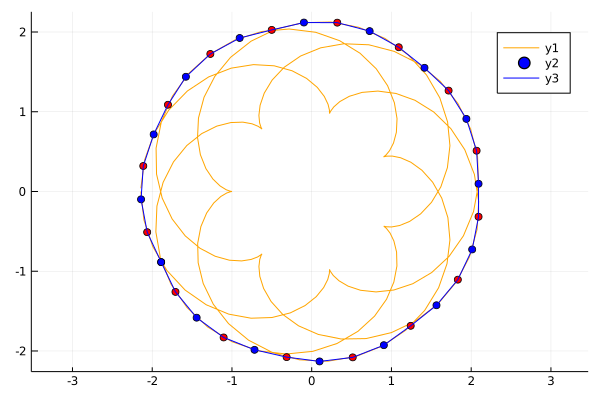

In [98]:
ts = get_ts(8*2^2,8pi,pi/7)
maxts = get_maxts(ts)

plot(x,y,0:0.314:22pi, color="orange", axisratio=:equal)
scatter!(x,y,maxts,color=["blue","red"])
plot!(x,y,maxts,color="blue")

Rahlo spremenjene funkcije za računanje integralov iz vaj. Glavna sprememba je, da namesto funkcije podamo vrednosti.

In [99]:
function sredinski(a,b,n)
    h = (b-a)/n
    utezi = h*ones(n)
    vozli = LinRange(a,b,n)
    return utezi,vozli
end
function integral_sredinski(vals,a,b,n)
    w,x = sredinski(a,b,n)
    return dot(w,vals)
end

function simpson(a,b,n)
    
    n = floor(Int,n/2)
    
    h = (b-a)/n
    vozli = LinRange(a,b,2n+1)
    utezi = h/6 * vcat([1],repeat([4,2],n-1),[4,1])
    
    return utezi, vozli
end

function integral_simpson(vals,a,b,n)
    w,x = simpson(a,b,n)
    return dot(w,vals)
end

integral_simpson (generic function with 1 method)

Zračunamo vrednosti integralov za različno število izbranih točk. Integriramo po polarnih koordinatah, torej je celotna ploščina pi*r^2, toraj moramo radij kvadrirati.

In [100]:
prbl_sr = []
prbl_si = []

for i=2:1:12
    display(8*2^i)
    ts = get_ts(8*2^i,8pi,pi/7)
    maxts = get_maxts(ts)
    
    vals = polar_d.(maxts)
    vals = vals.*vals
    prbl_sr = vcat(prbl_sr,integral_sredinski(vals,0,pi,size(vals)[1]))
    prbl_si = vcat(prbl_si,integral_simpson(vals,0,pi,size(vals)[1]))
end

32

64

128

256

512

1024

2048

4096

8192

16384

32768

Za vizualizacijo še zračunamo, koliko se rezultat spreminja s več točkami

In [102]:
err_sr = []
err_si = []

for i=2:size(prbl_sr)[1]
    err_sr = vcat(err_sr, abs(prbl_sr[i]-prbl_sr[i-1]))
    err_si = vcat(err_si, abs(prbl_si[i]-prbl_si[i-1]))
end

err_sr
err_si

10-element Array{Any,1}:
 0.0003655417112042869
 3.5640950168058794e-5
 1.782002436101493e-5 
 8.910018793883978e-6 
 1.1850500509780204e-6
 2.2496417528827806e-7
 1.1248209119685271e-7
 2.2972544755361923e-8
 3.1691467228256442e-9
 1.5845742495912418e-9

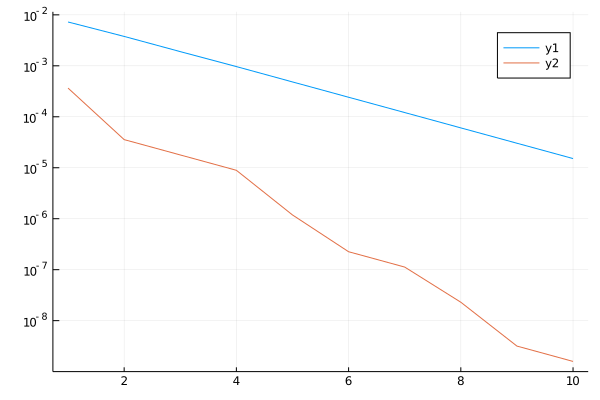

In [103]:
plot(err_sr,yaxis=:log)
plot!(err_si,yaxis=:log)

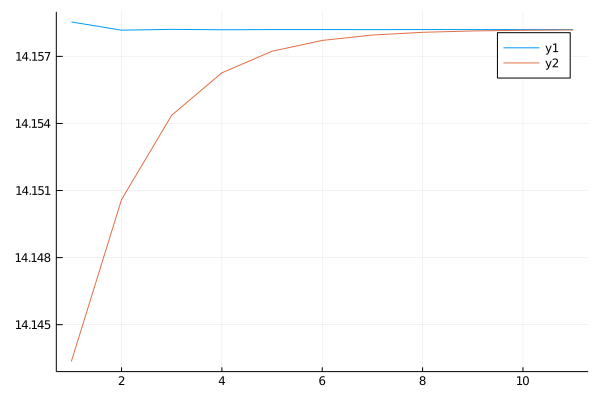

In [114]:
plot(prbl_si)
plot!(prbl_sr)